# Genetic Algorithm in the Traveling Salesman Problem
___
This notebook shows off how I've applied the Genetic Algorithm (GA) to the Traveling Salesman Problem (TSP). The code in this notebook generally finds a good path, if not the best path, given a list of points (Or a randomly generated set of points)  
___
  First all the required libraries are imported, Matplotlib is not necessary, but it helps to visualize the results of the GA

In [1]:
import math
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

### Cities
___
As we know, in the TSP, you must visit every city, before coming back to the first one. I opted to represent each city as an object, defined here as `Point`.

In [2]:
class Point:
    def __init__(self,x,y,pid):
        self.x=x
        self.y=y
        self.id=pid
        
    def __repr__(self):
        return str(self.id)
    
    def distance(p1,p2):
        return np.linalg.norm((p1.x-p2.x,p1.y-p2.y))

### Paths
___
The `Path` object is a simple wrapper around a list of `Points`. I've included a function to calculate the distance of the path (including going from the last city back to the first). In addition, a 'fitness' variable is stored, inversely proportional to the distance. This value is used to measure this path's performance in relation to other paths.

In [3]:
class Path:
    def __init__(self,path=[],shuffle=False):
        self.path=path.copy()
        self.doFitness()
        
    def doFitness(self):
        self.fitness = 1/self.distance()
        
    def distance(self):
        if len(self.path)==0:
            return 0
        return sum([Point.distance(self.path[i],self.path[i+1]) for i in range(len(self.path)-1)])+Point.distance(self.path[0],self.path[-1])
    
    def __repr__(self):
        return '[' + ','.join([str(x) for x in self.path])+']'

### Mutations and Breeding
___
As the name implies, a genetic algorithm applies the concepts of breeding and mutations to each individual present in the training population. Here are two utility methods:  
* `cross`, which combines two paths into one by taking a sequence of one path, and filling in the remainder from the second path  
* `mutate`, which randomly switches positions in the paths based on the `rate` value

In [4]:
def cross(p1,p2):
    pos1 = int(random.random()*len(p1.path))
    pos2 = int(random.random()*len(p1.path))
    start = min(pos1,pos2)
    end = max(pos1,pos2)
    selected = [x.id for x in p1.path[pos1:pos2+1]]
    new_points = []
    p2pos = 0
    for x in range(len(p1.path)):
        if p1.path[x].id in selected:
            new_points.append(p1.path[x])
        else:
            while p2.path[p2pos].id in selected:
                p2pos+=1
            new_points.append(p2.path[p2pos])
            p2pos+=1
    return Path(new_points)

def mutate(p,rate):
    for x in range(len(p.path)):
        if random.random()<rate:
            r = int(random.random()*len(p.path))
            p.path[x],p.path[r]=p.path[r],p.path[x]
    p.doFitness()
    return p

### The Population
___
In a genetic algorithm, the population refers to all the individuals that are being mutated, selected, and bred. In our problem, each individual is represented by a `Path` object, and their performance is equal to `1/distance`. The `Population` class automatically evolves each generation of paths from the previous generation.
#### Evolution
___
The `evolve` method is called to construct a new population pool from a random selection of the old pool. There are two main methods that are used in determining the new pool of individuals.  
1. The best individuals of the old pool carry on into the new pool, a concept called [elitism](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism)  
2. The remaining slots in the new pool are filled with individuals that are bred from the old pool.  
    * The pool of "parents" are chosen by repeatedly selecting a fraction of the population and taking the best one.  
  
  
  Thus, the worse performing individuals of the old generation have a greatly diminished effect on the individuals of the new population, so the overall performance of the population will continue to increase.

In [5]:
class Population:
    def __init__(self,points,size = 50,m_rate = 0.05,elite=0.10):
        self.size = size
        self.elite = elite
        self.m_rate = m_rate
        self.paths = []
        for i in range(size):
            random.shuffle(points)
            self.paths.append(Path(points,True))
        self.paths = self.fitSorted()
        
    def fitSorted(self,paths=None):
        if not paths:
            paths = self.paths
        return sorted(paths,key=lambda x : x.fitness)[::-1]
    
    def evolve(self):
        new_paths = []
        #Best 2 species from last gen
        new_paths.extend(self.fitSorted()[:int(self.elite*self.size)])
        breeding = []
        while len(breeding)<self.size:
            breeding.append(self.best_from_sample(self.size//3))
        while len(new_paths)<self.size:
            p1 = breeding[int(random.random()*len(breeding))]
            p2 = breeding[int(random.random()*len(breeding))]
            new_paths.append(cross(p1,p2))
        for x in new_paths:
            mutate(x,self.m_rate)
        self.paths=new_paths
        self.paths=self.fitSorted()

    def best_from_sample(self,sample_size):
        return self.fitSorted(random.sample(self.paths,sample_size))[0]

### Variables
___
You can try setting these variables on your own to see how they affect the population's performance (and runtime).

In [12]:
num_cities = 100
population_size = 200
num_generations = 500
mutation_rate = 0.10
elite_percentage = 0.10
stale_threshold = 15

### Running the Genetic Algorithm  
___
We can finally run our genetic algorithm. Here we are running on a set of `num_cities` randomly generated cities, within a 20 by 20 square. The algorithm is run for `num_generations` amount of generations before the best path is selected.
* Note that the algorithm will stop early if no progress is made `stale_threshold` after the last "breakthrough"

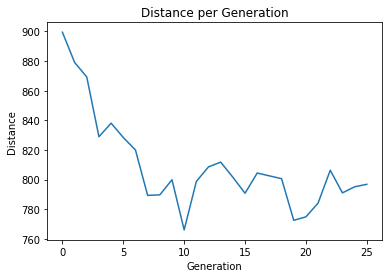

Finished after 500 generations:
Best Path Fitness: 0.0013052981959696677 
Best Path Distance: 766.1084670825959


In [13]:
def genetic_algorithm(cities):
    population = Population(cities,population_size,mutation_rate,elite_percentage)
    bests = []
    cur_best = None
    stale = 0
    cur_mut_rate = mutation_rate
    for i in range(num_generations):
        population.evolve()
        b = population.fitSorted()[0]
        x = b.distance()
        if i==0:
            cur_best = copy.deepcopy(b)
        else:
            bd = cur_best.distance()
            if x < bd:
                cur_best = copy.deepcopy(b)
                stale = 0
            else:
                stale+=1
        bests.append(b.distance())
        if stale >= stale_threshold:
            break
        cur_mut_rate -= 1/(num_generations*5)
        population.m_rate = cur_mut_rate
    plt.plot(bests)
    plt.title('Distance per Generation')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.show()
    f_text = 'Finished after ' + str(num_generations) +' generations:\n'
    print(f_text + 'Best Path Fitness:',cur_best.fitness,'\nBest Path Distance:',cur_best.distance())
    return cur_best


cities = [Point(random.random()*20,random.random()*20,i) for i in range(num_cities)]
best = genetic_algorithm(cities)

### Comparing with Known Paths
___
Finally, we can also run our genetic algorithm on a set of known points (stored in `points.csv`). The output is the ratio of our calculated distance to the known distance (always at least 1).

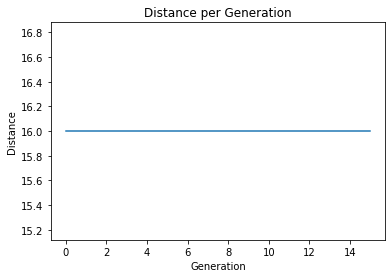

Finished after 500 generations:
Best Path Fitness: 0.0625 
Best Path Distance: 16.0
A4: 1.0


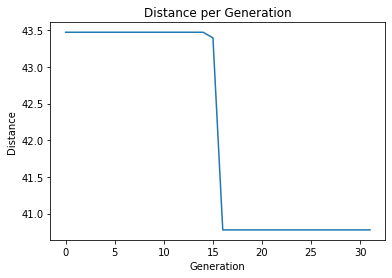

Finished after 500 generations:
Best Path Fitness: 0.024523360742131146 
Best Path Distance: 40.7774452496635
A8: 1.00001


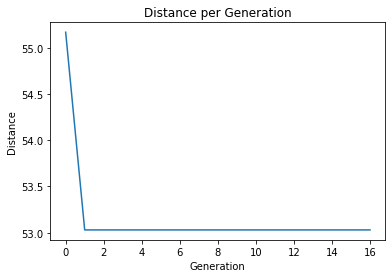

Finished after 500 generations:
Best Path Fitness: 0.01885723309207667 
Best Path Distance: 53.03004927165983
A9: 1.01867


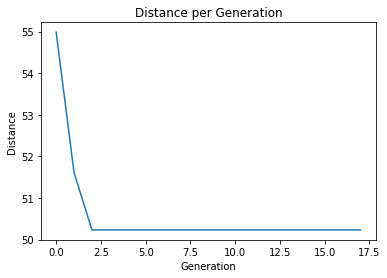

Finished after 500 generations:
Best Path Fitness: 0.019907664216216793 
Best Path Distance: 50.23191013968376
A9-2: 1.00002


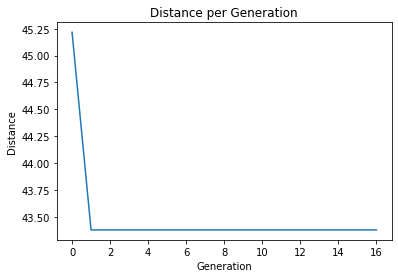

Finished after 500 generations:
Best Path Fitness: 0.023053129613084398 
Best Path Distance: 43.37805828465148
A10: 1.0


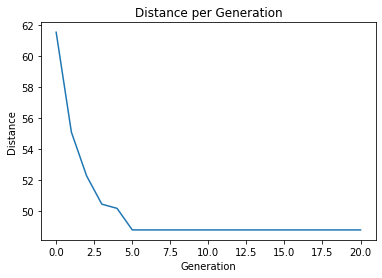

Finished after 500 generations:
Best Path Fitness: 0.02048995107165869 
Best Path Distance: 48.804411318638095
A11: 1.00001


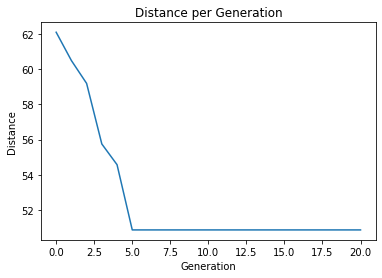

Finished after 500 generations:
Best Path Fitness: 0.019655695687977245 
Best Path Distance: 50.875838529168306
A12: 1.0


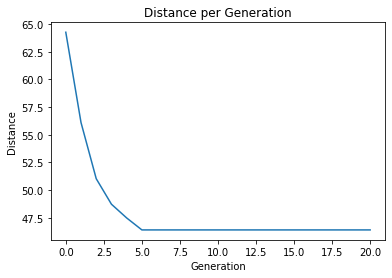

Finished after 500 generations:
Best Path Fitness: 0.02155497936080643 
Best Path Distance: 46.39299269375813
A12-2: 1.0


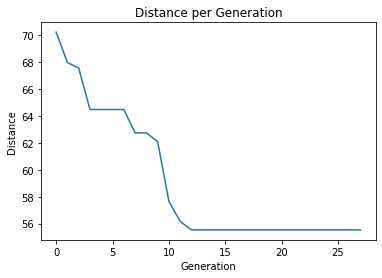

Finished after 500 generations:
Best Path Fitness: 0.01800760672319531 
Best Path Distance: 55.53208793214681
A13: 1.0


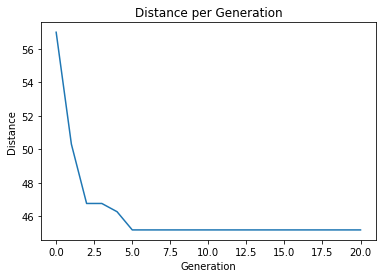

Finished after 500 generations:
Best Path Fitness: 0.022128794550145027 
Best Path Distance: 45.189989799667885
A13-2: 1.0


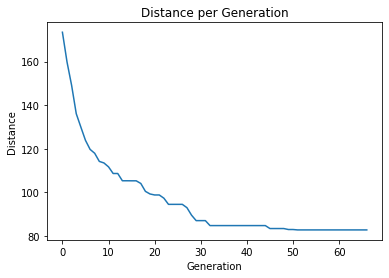

Finished after 500 generations:
Best Path Fitness: 0.012091810598798209 
Best Path Distance: 82.70060069410853
A30: 0.98768


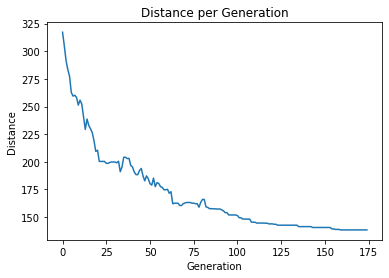

Finished after 500 generations:
Best Path Fitness: 0.007225722308031422 
Best Path Distance: 138.39446872854435
A50: 1.00224


In [14]:
with open("points.csv") as f:
    lines = f.readlines()
bests = []
for j in range(0,len(lines),5):
    if len(lines[j].strip())==0:
        break
    xPos = [int(x) for x in lines[j+1].split(',')]
    yPos = [int(x) for x in lines[j+2].split(',')]
    cities = [Point(xPos[i],yPos[i],i) for i in range(len(xPos))]
    ans = lines[j+3]
    best = genetic_algorithm(cities)
    name = lines[j].split(',')[0]
    bests.append((name,best))
    print(name+str(':'),round(best.distance()/float(lines[j].split(',')[1]),5))
#Output to another csv file
with open("StudentPaths.csv",'w+') as f:
    for x in bests:
        name,best = x
        out = name+'\n'
        for i in best.path:
            out+=str(i)+','
        out = out[:-1]+'\n'
        f.write(out)

### Challenges Encountered
___
I encountered some odd problems while creating this genetic algorithm solution to the Traveling Salesman Problem. Many of these problems stemmed from weird list-indexing, which was easily fixed once I realized. However, one problem that was frustrating for a while was that the *overall* best member wouldn't be returned, only the best member *from the last generation*. This was fixed once I realized that the problem was that each Path was being changed in place, so thus, the `copy.deepcopy()` was necessary.  
  
  Once all the bugs were ironed out, the algorithm has worked extremely well.